# 1) Import Libraries

In [ ]:
!pip install copick git+https://github.com/copick/copick-utils.git scikit-image cupy-cuda12x torch torchvision tqdm matplotlib

import numpy as np
from glob import glob
import os
import pandas as pd
import zarr
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from mpl_toolkits.mplot3d import Axes3D

  Cloning https://github.com/copick/copick-utils.git to /tmp/pip-req-build-q5bjw6e5
  Running command git clone --filter=blob:none --quiet https://github.com/copick/copick-utils.git /tmp/pip-req-build-q5bjw6e5
  Resolved https://github.com/copick/copick-utils.git to commit 79315f3fca71ebfaaff54198b3e08a3bd2ebc63f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# 2) Load Zarr Data and Centroids (from JSON)

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def read_zarr(run: str) -> zarr.hierarchy.Group:
    return zarr.open(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/static/ExperimentRuns/{run}/VoxelSpacing10.000/denoised.zarr", mode="r")

def read_run(run: str) -> pd.DataFrame:
    paths = glob(f"/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/{run}/Picks/*.json")
    df = pd.concat([pd.read_json(x) for x in paths]).reset_index(drop=True)
    for axis in "x", "y", "z":
        df[axis] = df.points.apply(lambda x: x["location"][axis])
    return df

# 3) Data Preprocessing

## Convert Centroids to Voxels

In [ ]:
def map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=(100, 100, 100)):
    voxel_labels = np.zeros(volume_shape, dtype=int)
    for _, row in df.iterrows():
        x, y, z = [int(row[axis] / voxel_spacing) for axis in ['x', 'y', 'z']]
        voxel_labels[z, y, x] = 1 if row['pickable_object_name'] == 'apo-ferritin' else 0
    return voxel_labels

## Expand Centroids into Blobs

In [ ]:
def expand_labels_with_blobs(voxel_labels, radius):
    radius = int(radius)
    z, y, x = np.ogrid[-radius:radius+1, -radius:radius+1, -radius:radius+1]
    distance = np.sqrt(x**2 + y**2 + z**2)
    sphere = distance <= radius

    expanded_labels = np.zeros_like(voxel_labels, dtype=np.uint8)
    centroids = np.argwhere(voxel_labels == 1)

    for centroid in centroids:
        cz, cy, cx = centroid
        z_min, z_max = max(0, cz - radius), min(voxel_labels.shape[0], cz + radius + 1)
        y_min, y_max = max(0, cy - radius), min(voxel_labels.shape[1], cy + radius + 1)
        x_min, x_max = max(0, cx - radius), min(voxel_labels.shape[2], cx + radius + 1)
        roi = expanded_labels[z_min:z_max, y_min:y_max, x_min:x_max]
        roi[sphere] = 1
    return expanded_labels

## Create Subvolumes

In [ ]:
def preprocess_and_filter_subvolumes(zarr_data, labels, target_shape=(32, 32, 32), background_fraction=0.2, normalize=True):
    sub_volumes = []
    sub_labels = []
    background_volumes = []
    background_labels = []

    for x in range(0, zarr_data.shape[0] - target_shape[0] + 1, target_shape[0]):
        for y in range(0, zarr_data.shape[1] - target_shape[1] + 1, target_shape[1]):
            for z in range(0, zarr_data.shape[2] - target_shape[2] + 1, target_shape[2]):
                crop = zarr_data[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                crop_label = labels[x:x + target_shape[0], y:y + target_shape[1], z:z + target_shape[2]]
                if np.any(crop_label == 1):
                    sub_volumes.append(crop)
                    sub_labels.append(crop_label)
                else:
                    background_volumes.append(crop)
                    background_labels.append(crop_label)

    if background_fraction > 0 and len(background_volumes) > 0:
        sample_size = int(len(sub_volumes) * background_fraction)
        sampled_indices = np.random.choice(len(background_volumes), size=sample_size, replace=False)
        sub_volumes.extend([background_volumes[i] for i in sampled_indices])
        sub_labels.extend([background_labels[i] for i in sampled_indices])
    if normalize:
        return ((np.array(sub_volumes) - np.min(np.array(sub_volumes))) / (np.max(np.array(sub_volumes)) - np.min(np.array(sub_volumes)))), np.array(sub_labels)
    return np.array(sub_volumes), np.array(sub_labels)

In [ ]:
# Creates a list with the names of the experiments
runs = sorted(glob('/content/drive/MyDrive/DL2_Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/*'))
runs = [os.path.basename(x) for x in runs]
print(runs)
print(f"We use this experiment {runs[1]}, but you should be able \nto also add information of the other experiments")

['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3', 'TS_99_9']
We use this experiment TS_69_2, but you should be able 
to also add information of the other experiments


In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_filtered_volumes = []
all_filtered_labels = []

for run in tqdm(runs, desc="Processing experiments"):
    zarr_data_nparray = read_zarr(run)

    df = read_run(run)

    voxel_labels = map_overlay_to_voxels(df, voxel_spacing=10, volume_shape=zarr_data_nparray["0"].shape)

    voxel_labels_tensor = torch.tensor(voxel_labels, dtype=torch.float32).to(device)

    radius_apo_ferritin = 3  # Radius in voxels
    voxel_labels_blob = expand_labels_with_blobs(voxel_labels_tensor.cpu().numpy(), radius=radius_apo_ferritin)

    filtered_volumes, filtered_labels = preprocess_and_filter_subvolumes(
        zarr_data_nparray["0"], voxel_labels_blob, target_shape=(32, 32, 32), background_fraction=0, normalize=True
    )

    filtered_volumes_tensor = torch.tensor(filtered_volumes, dtype=torch.float32).to(device)
    filtered_labels_tensor = torch.tensor(filtered_labels, dtype=torch.float32).to(device)

    all_filtered_volumes.append(filtered_volumes_tensor.cpu().numpy())
    all_filtered_labels.append(filtered_labels_tensor.cpu().numpy())

all_filtered_volumes = np.concatenate(all_filtered_volumes, axis=0)
all_filtered_labels = np.concatenate(all_filtered_labels, axis=0)

print(f"All filtered volumes shape: {all_filtered_volumes.shape}")
print(f"All filtered labels shape: {all_filtered_labels.shape}")

Processing experiments: 100%|██████████| 7/7 [24:53<00:00, 213.38s/it]

All filtered volumes shape: (393, 32, 32, 32)
All filtered labels shape: (393, 32, 32, 32)


In [ ]:
from torch.utils.data import DataLoader, random_split, TensorDataset

train_dataset = TensorDataset(
    torch.tensor(all_filtered_volumes).unsqueeze(1).float(),  # Shape: [batch_size, 1, D, H, W]
    torch.tensor(all_filtered_labels).unsqueeze(1).float()   # Shape: [batch_size, 1, D, H, W]
)

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

dataset_size = len(train_dataset)

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    train_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


Epoch 10, Train Loss: 0.1266, Validation Loss: 0.1149
Epoch 10, Loss: 0.1266
Epoch 20, Train Loss: 0.0669, Validation Loss: 0.0647
Epoch 20, Loss: 0.0669
Epoch 30, Train Loss: 0.0523, Validation Loss: 0.0546
Epoch 30, Loss: 0.0523
Epoch 40, Train Loss: 0.0464, Validation Loss: 0.0495
Epoch 40, Loss: 0.0464
Epoch 50, Train Loss: 0.0415, Validation Loss: 0.0455
Epoch 50, Loss: 0.0415
Epoch 60, Train Loss: 0.0375, Validation Loss: 0.0428
Epoch 60, Loss: 0.0375
Epoch 70, Train Loss: 0.0343, Validation Loss: 0.0427
Epoch 70, Loss: 0.0343
Epoch 80, Train Loss: 0.0317, Validation Loss: 0.0397
Epoch 80, Loss: 0.0317
Epoch 90, Train Loss: 0.0291, Validation Loss: 0.0392
Epoch 90, Loss: 0.0291
Epoch 100, Train Loss: 0.0270, Validation Loss: 0.0384
Epoch 100, Loss: 0.0270


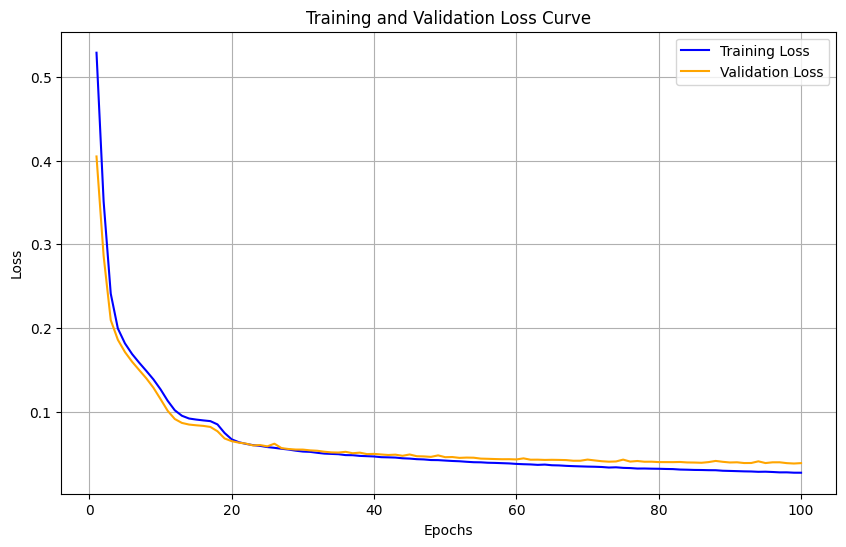

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(4, out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(4, out_channels)
        self.relu = nn.PReLU()

        self.residual_conv = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))

        if self.residual_conv is not None:
            residual = self.residual_conv(residual)

        return self.relu(x + residual)


class VNet3D(nn.Module):
    def __init__(self, num_classes=1):
        super(VNet3D, self).__init__()

        # Contracting Path
        self.enc1 = ResidualBlock(1, 8)
        self.pool1 = nn.Conv3d(8, 8, kernel_size=2, stride=2)

        self.enc2 = ResidualBlock(8, 16)
        self.pool2 = nn.Conv3d(16, 16, kernel_size=2, stride=2)

        self.enc3 = ResidualBlock(16, 32)
        self.pool3 = nn.Conv3d(32, 32, kernel_size=2, stride=2)

        # Bottleneck
        self.bottleneck = ResidualBlock(32, 64)

        # Expanding Path
        self.upconv3 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock(32, 32)

        self.upconv2 = nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(16, 16)

        self.upconv1 = nn.ConvTranspose3d(16, 8, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(8, 8)

        # Output Layer
        self.final_conv = nn.Conv3d(8, num_classes, kernel_size=1)

    def forward(self, x):
        # Contracting Path
        enc1 = self.enc1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.enc2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.enc3(pool2)
        pool3 = self.pool3(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(pool3)

        # Expanding Path
        up3 = self.upconv3(bottleneck)
        dec3 = self.dec3(up3 + enc3)

        up2 = self.upconv2(dec3)
        dec2 = self.dec2(up2 + enc2)

        up1 = self.upconv1(dec2)
        dec1 = self.dec1(up1 + enc1)

        # Output Layer
        output = self.final_conv(dec1)
        return output



model = VNet3D().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
pos_weight = torch.tensor([5.0]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    epoch_loss = 0
    num_batches = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.float().to(device), labels.float().to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    scheduler.step(epoch_loss)
    train_losses.append(epoch_loss)

    model.eval()
    val_epoch_loss = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()

    avg_val_loss = val_epoch_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch + 1}, "
            f"Train Loss: {epoch_loss:.4f}, "
            f"Validation Loss: {avg_val_loss:.4f}"
        )

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')


model.eval()
with torch.no_grad():
    sample_input = torch.tensor(filtered_volumes[0]).unsqueeze(0).unsqueeze(1).float().to(device)
    predicted = model(sample_input).cpu().numpy()

predicted_slice = np.take(predicted[0], filtered_labels[0].shape[2] // 2, axis=2)
true_slice = np.take(filtered_labels[0], filtered_labels[0].shape[2] // 2, axis=2)

predicted_slice = np.squeeze(predicted_slice)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "vnet_model_apo-ferritin.pth")

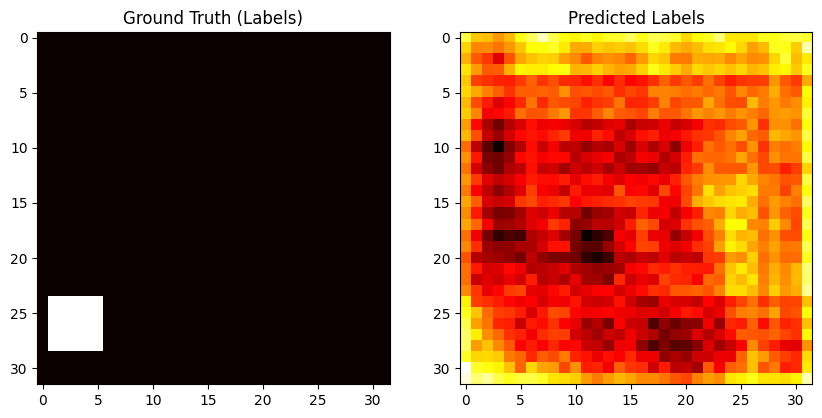

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(true_slice, cmap='hot')
axes[0].set_title('Ground Truth (Labels)')
axes[1].imshow(predicted_slice, cmap='hot')
axes[1].set_title('Predicted Labels')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score


all_true_labels = []
all_predicted_labels = []

for inputs, labels in train_loader:
    inputs, labels = inputs.float().to(device), labels.float().to(device)
    outputs = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)

    all_true_labels.append(labels.flatten().cpu().numpy())
    all_predicted_labels.append((outputs.flatten() > 0.5).cpu().numpy())

all_true_labels = np.concatenate(all_true_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)

precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.5553
Recall: 0.4890
F1 Score: 0.5200


In [ ]:
all_true_labels = []
all_predicted_labels = []

for inputs, labels in test_loader:
    inputs, labels = inputs.float().to(device), labels.float().to(device)
    outputs = model(inputs)
    outputs = F.interpolate(outputs, size=labels.shape[2:], mode='trilinear', align_corners=True)

    all_true_labels.append(labels.flatten().cpu().numpy())
    all_predicted_labels.append((outputs.flatten() > 0.5).cpu().numpy())

all_true_labels = np.concatenate(all_true_labels)
all_predicted_labels = np.concatenate(all_predicted_labels)

precision = precision_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels)
f1 = f1_score(all_true_labels, all_predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.4140
Recall: 0.3807
F1 Score: 0.3966
